<a href="https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%2017/2_0_jrvae_cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   This notebook takes you through the application of rotationally invariant joint variational autoencoder (jrVAE) on four different cards datasets and the results analysis.  
*   Each cards dataset if formed by applying a random rotation and shear to the images of the cards. The datasets differ in the limits used for picking the rotations and shear.

*   rVAE comprises of an additional latent dimension to the regular VAE, which explicitly captures the rotations involved in the image.
*   This angular latent dimension is unsupervisedly learned while trying to reconstuct the original image.
*   Like in VAE, this latent dimension is also regularized using a prior.  

*   joint variational autoencoder has latent dimensions that encode discrete class probabilities along with the continuous encodings of the regular VAE.
*   One can have multiple discrete-dimensions but in this notebook, only the case with one discrete dimension is explored.
*   This discrete dimension encodes the dataset into four classes ideally corresponding to suits in the input dataset.
*   But the results of the jrVAE encodings are not optimal as it is sensitive to the channel capacities used while training. Here we haven't optimized the channel capacities and the default values from the atomai-package are used.
*   Please see DOI: 10.1088/2632-2153/acb316 for further details on optimizing the channel capacities while training




The jrVAEs are defined and trained using a package called atomai (https://github.com/pycroscopy/atomai) which is built on top of PyTorch framework. Please feel free to write to valletisai.mani@gmail.com for further enquiries.

In [ ]:
# Installing atomai and pyroved
!pip install -q kornia git+https://github.com/saimani5/atomai

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 KB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.1/503.1 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 KB 39.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.


In [ ]:
# Importing necessary packages
import atomai as aoi
import kornia as K
import cv2
import torch
import torch.nn as nn
tt = torch.tensor
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3

In [ ]:
#@title Helper functions that apply afffine transformations to the dataset
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


import math
def transform_imgs(cards, **kwargs):
    np.random.seed(0)
    torch.manual_seed(0)

    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = (kwargs.get("shear"))
    if s is not None:
        s = math.radians(s)


    n_samples = kwargs.get("samples", 3000)
    n_samples_total = n_samples*4

    card1, card2, card3, card4 = cards[0], cards[1], cards[2], cards[3]

    card1 = card1[None, None].repeat_interleave(n_samples, dim = 0)
    card2 = card2[None, None].repeat_interleave(n_samples, dim = 0)
    card3 = card3[None, None].repeat_interleave(n_samples, dim = 0)
    card4 = card4[None, None].repeat_interleave(n_samples, dim = 0)

    cards_all = torch.cat((card1, card2, card3, card4), dim = 0)

    angles = tt(np.random.uniform(low = -a, high = a, size = [n_samples_total]))
    translations = tt(np.random.uniform(low = -t, high = t, size = [n_samples_total,1])).repeat_interleave(2, dim = 1)
    shears = tt(np.random.uniform(low = -s, high = s, size = [n_samples_total, 1])).repeat_interleave(2, dim = 1)

    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.geometry.Affine(angle = angles, translation = translations,
                          shear = shears)
    )

    cards = transform(cards_all).squeeze().float()
    labels = torch.cat([torch.zeros(len(card1)), torch.ones(len(card2)),
                           2*torch.ones(len(card3)), 3*torch.ones(len(card4))])
    return cards, labels, angles, translations, shears


def plot_manifolds(model):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

Here we make 4 different datasets using the above helper functions which are as follows:  
*  cards-i: low rotations (12 degrees) and low shear (1 degree)
*  cards-ii: low rotations (12 degrees) and high shear (20 degrees)
*  cards-iii: high rotations (120 degrees) and low shear (1 degree)
*  cards-iv: high rotations (120 degrees) and high shear (20 degrees)

In [ ]:
# Downloading the cards dataset
!gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip -o -qq cards.zip

In [ ]:
# And the ground truth values of the transformations applied to analyze the latent spaces.
cards = get_data()
cards_all1, labels_all1, angles_all1, translations_all1, shears_all1 = transform_imgs(cards, angle = 12, translation = 0.1, shear = 1, samples = 3000)
cards_all2, labels_all2, angles_all2, translations_all2, shears_all2 = transform_imgs(cards, angle = 12, translation = 0.1, shear = 20, samples = 3000)
cards_all3, labels_all3, angles_all3, translations_all3, shears_all3 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 1, samples = 3000)
cards_all4, labels_all4, angles_all4, translations_all4, shears_all4 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 20, samples = 3000)

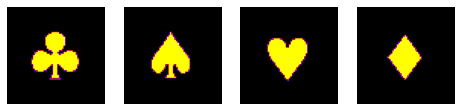

In [ ]:
# Visualizing the cards before applying transformations
fig, ax = plt.subplots(ncols = 4, figsize = (8,2))
for i in range(4):
    ax[i].imshow(cards[i], cmap = 'gnuplot')
    ax[i].axis('off')

# Training the atomai models for four datasets
Here we train one model of jrVAE per dataset and save the weights.  
These weights will be loaded into the notebook in the next section to avoid the time consuming training process

In [ ]:
# Training the rVAE on cards-i
input_dim = (48,48)   # Input dimensions of the dataset i.e., shape of each card's image
# Initializing the network
jrvae1 = aoi.models.jrVAE(input_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                          discrete_dim=[4],   # Number of discrete dimensions
                          numlayers_encoder=4,   # Number of hidden layers in the encoder
                          numhidden_encoder=1024,   # Number of neurons in each of the hidden layers in the encoder
                          numlayers_decoder=4,   # Number of hidden layers in the decoder
                          numhidden_decoder=1024,   # Number of neurons in each of the hidden layers in the decoder
                          skip=True, seed = 0)

jrvae1.fit(cards_all1, training_cycles=200, batch_size=100, loss="ce",   # Cross-entropy loss
           translation_prior=0.1,  # Prior for translational invariance
         filename='jrvae1')   # Saving the trained model

In [ ]:
# Training the rVAE on cards-ii
input_dim = (48,48)   # Input dimensions of the dataset i.e., shape of each card's image
# Initializing the network
jrvae2 = aoi.models.jrVAE(input_dim, latent_dim=2,  # Number of latent dimensions other than the invariancies
                          discrete_dim=[4],   # Number of discrete dimensions
                          numlayers_encoder=4,   # Number of hidden layers in the encoder
                          numhidden_encoder=1024,   # Number of neurons in each of the hidden layers in the encoder
                          numlayers_decoder=4,   # Number of hidden layers in the decoder
                          numhidden_decoder=1024,   # Number of neurons in each of the hidden layers in the decoder
                          skip=True, seed = 0)

jrvae2.fit(cards_all2, training_cycles=200, batch_size=100, loss="ce",   # Cross-entropy loss
           translation_prior=0.1,  # Prior for translational invariance
         filename='jrvae2')   # Saving the trained model

In [ ]:
# Training the rVAE on cards-iii
input_dim = (48,48)   # Input dimensions of the dataset i.e., shape of each card's image
# Initializing the network
jrvae3 = aoi.models.jrVAE(input_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                          discrete_dim=[4],   # Number of discrete dimensions
                          numlayers_encoder=4,   # Number of hidden layers in the encoder
                          numhidden_encoder=1024,   # Number of neurons in each of the hidden layers in the encoder
                          numlayers_decoder=4,   # Number of hidden layers in the decoder
                          numhidden_decoder=1024,   # Number of neurons in each of the hidden layers in the decoder
                          skip=True, seed = 0)

jrvae3.fit(cards_all3, training_cycles=200, batch_size=100, loss="ce", # Cross-entropy loss
           translation_prior=0.1,  # Prior for translational invariance
           filename='jrvae3')   # Saving the trained model

In [ ]:
# Training the rVAE on cards-iv
input_dim = (48,48)   # Input dimensions of the dataset i.e., shape of each card's image
# Initializing the network
jrvae4 = aoi.models.jrVAE(input_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                          discrete_dim=[4],   # Number of discrete dimensions
                          numlayers_encoder=4,   # Number of hidden layers in the encoder
                          numhidden_encoder=1024,   # Number of neurons in each of the hidden layers in the encoder
                          numlayers_decoder=4,   # Number of hidden layers in the decoder
                          numhidden_decoder=1024,   # Number of neurons in each of the hidden layers in the decoder
                          skip=True, seed = 0)

jrvae4.fit(cards_all4, training_cycles=200, batch_size=100, loss="ce",   # Cross-entropy loss
           translation_prior=0.1,   # Prior for translational invariance
         filename='jrvae4')   # Saving the trained model

# Analyzing the results

## cards-i
Low rotation (12 deg) and low shear (1 deg)

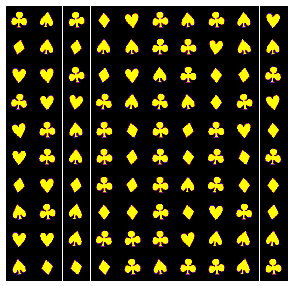

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all1))
    ax.imshow(cards_all1[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Downloading the saved model
!gdown 14CMocF-3b61RrbEdzMvtKny4Y7I-DHa6

# Loading the saved model
jrvae1 = aoi.load_model('jrvae11.tar')

Downloading...
From: https://drive.google.com/uc?id=14CMocF-3b61RrbEdzMvtKny4Y7I-DHa6
To: /content/jrvae11.tar
100% 117M/117M [00:03<00:00, 34.4MB/s]


Traverse Manifolds


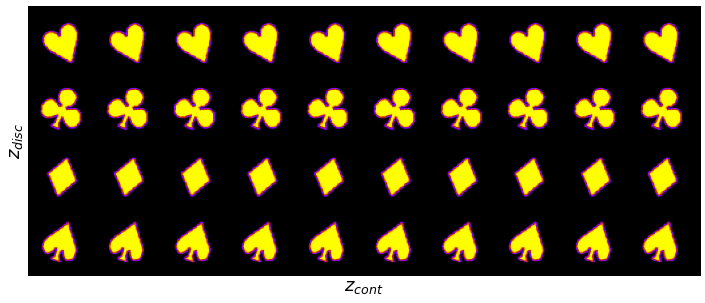

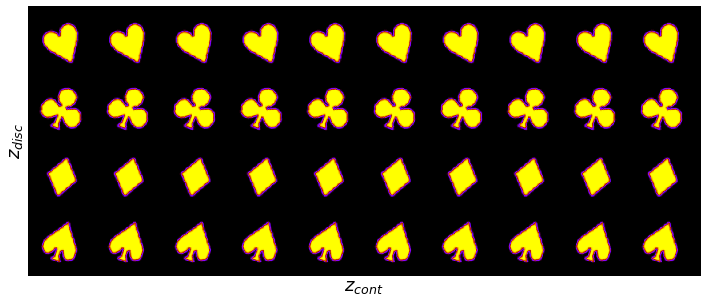

In [ ]:
# Traverse Manifolds

# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions.
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
# Since the latent space of crVAE is conditioned on the class label, we get one latent space for each class

# Traverse manifold is the decoded latent space in which one of the continouous latent dimension is held at constant (0),
# While the other continuous dimensions and the discrete dimension are used to plot the decoded latent space.

print('Traverse Manifolds')
for i in range(2):
    jrvae1.manifold_traversal(i, origin="upper")

Full class manifolds


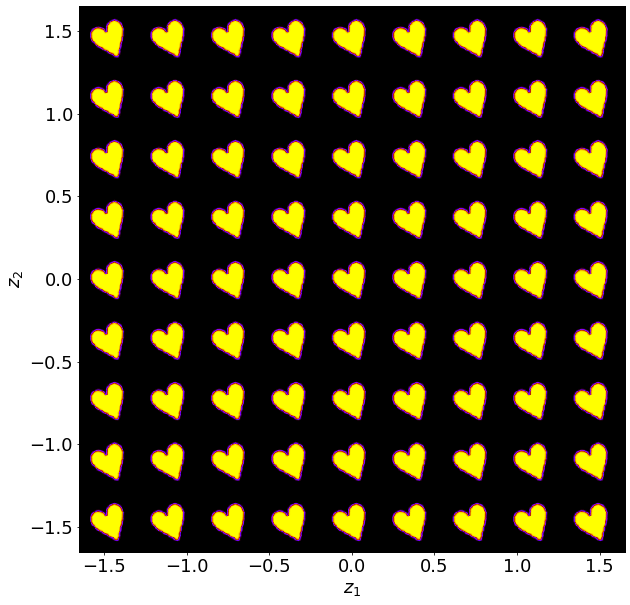

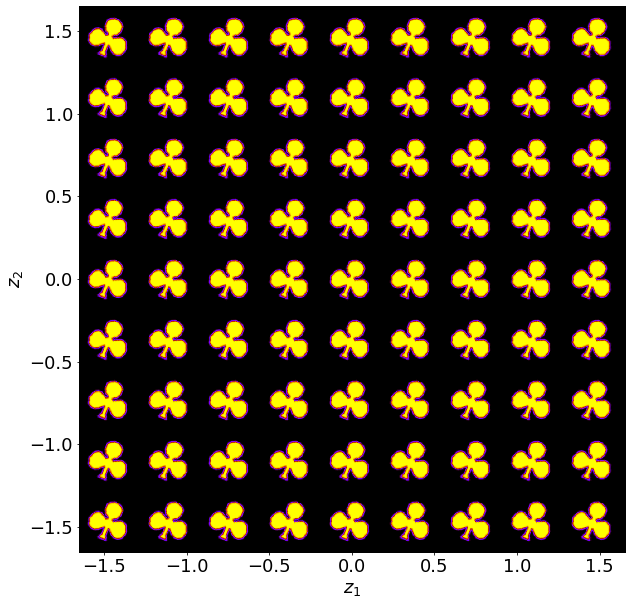

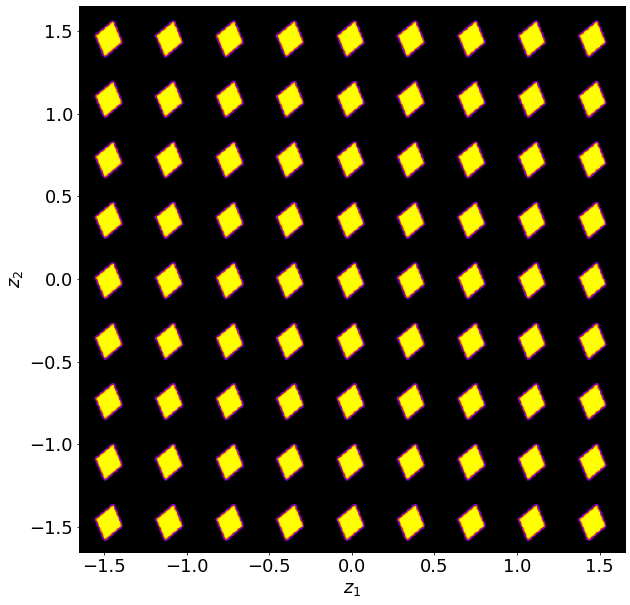

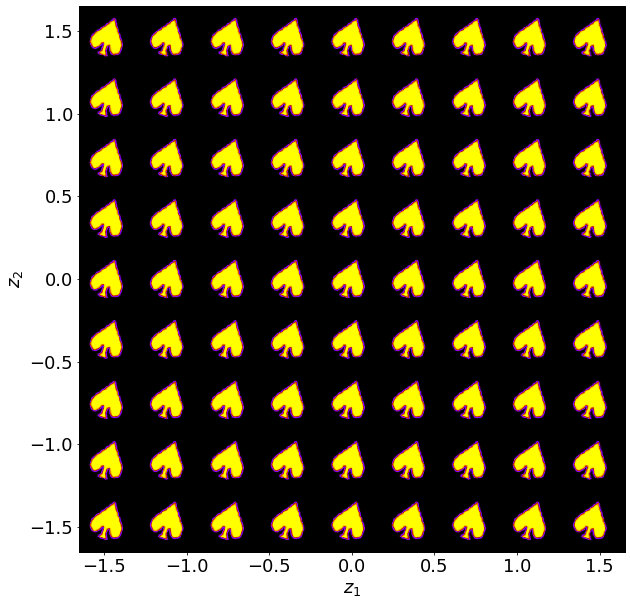

In [ ]:
# Decoded latent space of each class
print('Full class manifolds')
for i in range(4):
    jrvae1.manifold2d(d=9, disc_idx=i, origin="upper")

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution

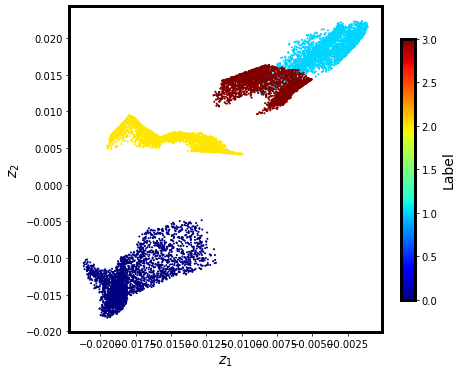

In [ ]:
z_mean1, z_sd1, alpha_all1 = jrvae1.encode(cards_all1)  # Encoding the full input dataset
# z_mean1: mean of the latent space representation of the input dataset,
# z_sd1: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions)
# alpha_all1: corresponds to the encoding in the discrete dimension

# Latent distribution colored using the ground-truth suit of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean1[:,-1], z_mean1[:,-2], c=labels_all1, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

# It should be noted that these points live in 4 independent latent spaces corresponding to the encodings in discrete dimension

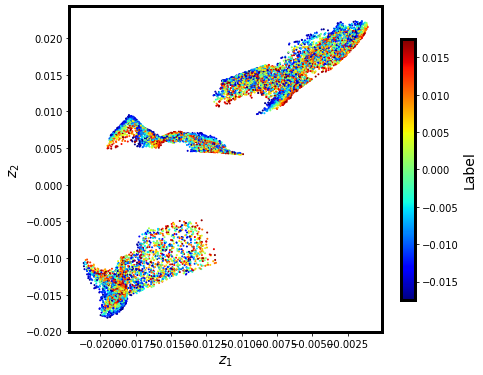

In [ ]:
# Latent distribution colored using the ground-truth shear of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean1[:,-1], z_mean1[:,-2], c=shears_all1[:,0], s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

# It should be noted that these points live in 4 independent latent spaces corresponding to the encodings in discrete dimension

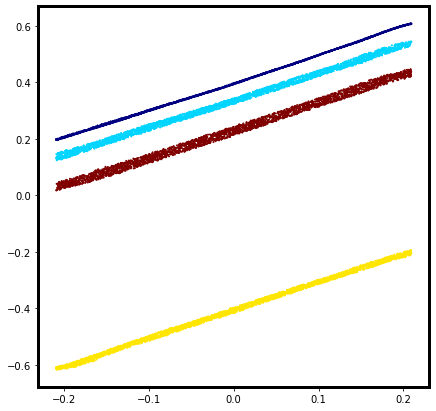

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images.
# The points are colored using the suit of the images.
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_all1), z_mean1[:,0], c = labels_all1, s =1, cmap = 'jet')

## cards-ii
Low rotation (12 deg) High shear (20deg)

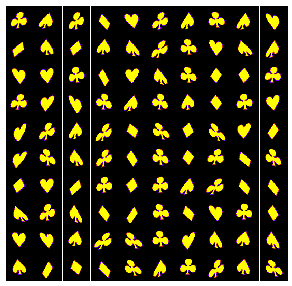

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all2))
    ax.imshow(cards_all2[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Download the saved model
!gdown 1UKuxifRaxNWCJOLQQvSRl0LOAD1Yveas

# Loading the saved model
jrvae2 = aoi.load_model('jrvae21.tar')

Downloading...
From: https://drive.google.com/uc?id=1UKuxifRaxNWCJOLQQvSRl0LOAD1Yveas
To: /content/jrvae21.tar
100% 117M/117M [00:00<00:00, 131MB/s]


Traverse Manifolds


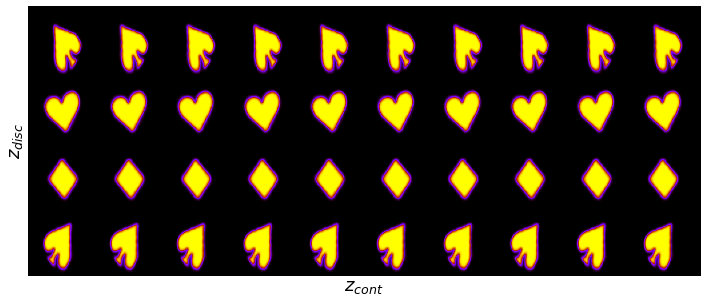

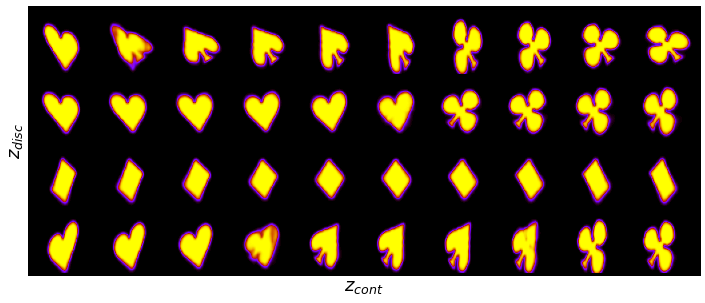

In [ ]:
# Traverse Manifolds

# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions.
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
# Since the latent space of crVAE is conditioned on the class label, we get one latent space for each class

# Traverse manifold is the decoded latent space in which one of the continouous latent dimension is held at constant (0),
# While the other continuous dimensions and the discrete dimension are used to plot the decoded latent space.
print('Traverse Manifolds')
for i in range(2):
    jrvae2.manifold_traversal(i, origin="upper")

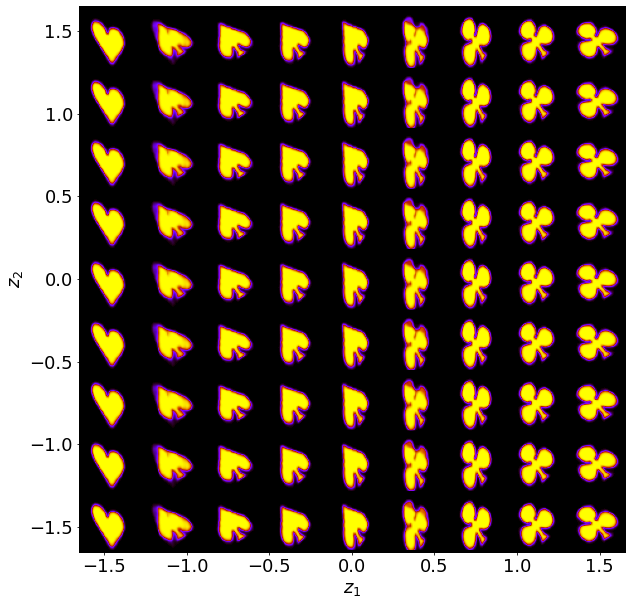

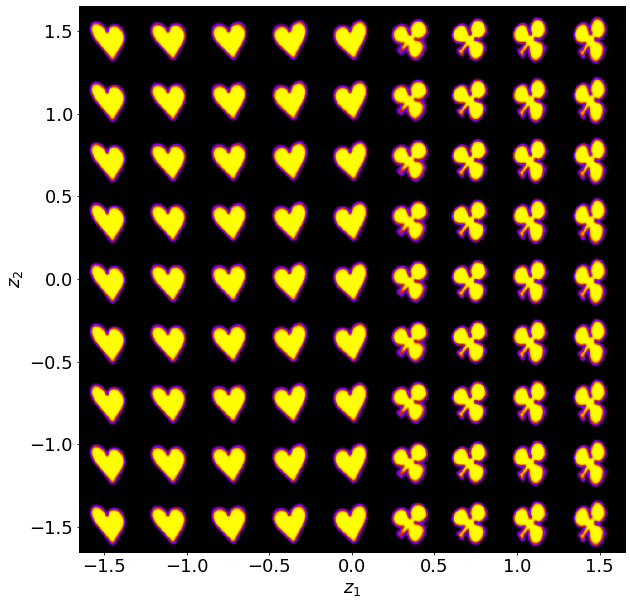

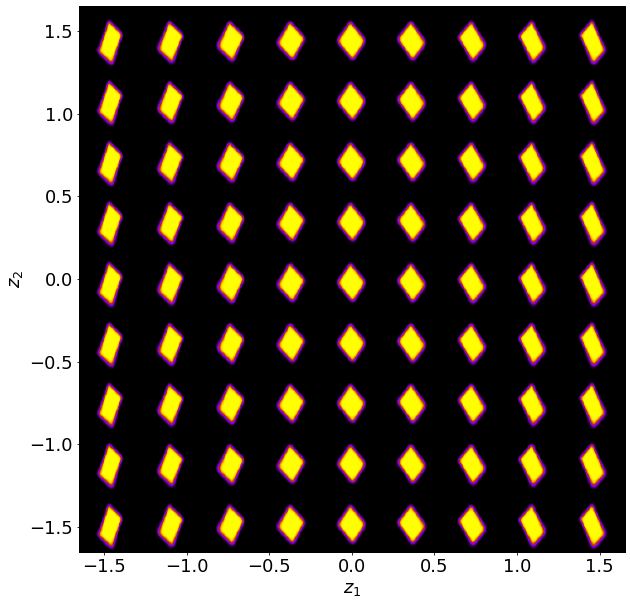

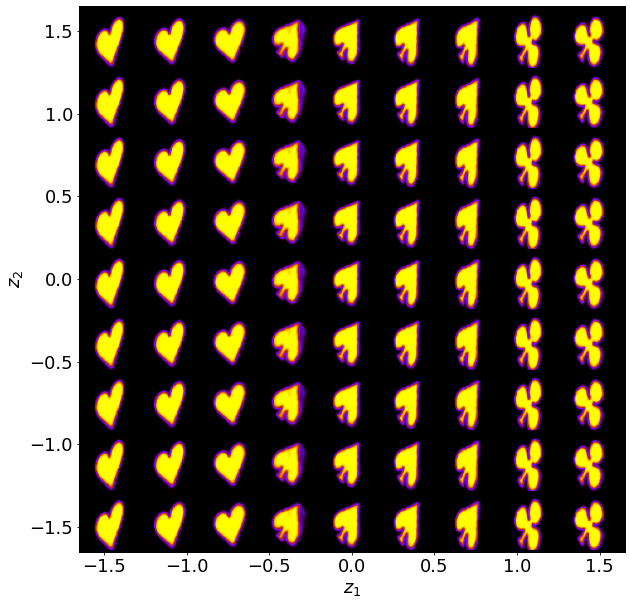

In [ ]:
# Decoded latent space of each class
for i in range(4):
    jrvae2.manifold2d(d=9, disc_idx=i, origin="upper")

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution

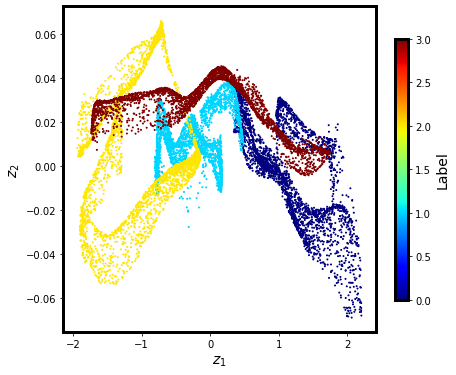

In [ ]:
z_mean2, z_sd2, alpha_all2 = jrvae2.encode(cards_all2)   # Encoding the full input dataset
# z_mean2: mean of the latent space representation of the input dataset,
# z_sd2: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions)
# alpha_all2: corresponds to the encoding in the discrete dimension

# Latent distribution colored using the ground-truth suit of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean2[:,-1], z_mean2[:,-2], c=labels_all2, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

# It should be noted that these points live in 4 independent latent spaces corresponding to the encodings in discrete dimension

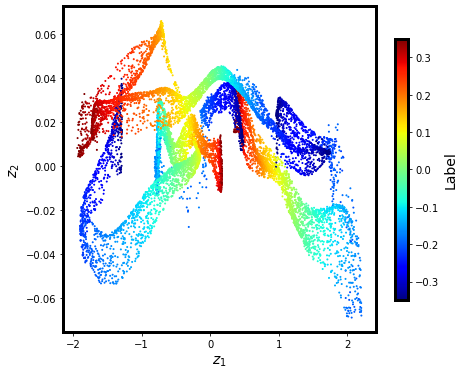

In [ ]:
# Latent distribution colored using the ground-truth shear of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean2[:,-1], z_mean2[:,-2], c=shears_all2[:,0], s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

# It should be noted that these points live in 4 independent latent spaces corresponding to the encodings in discrete dimension

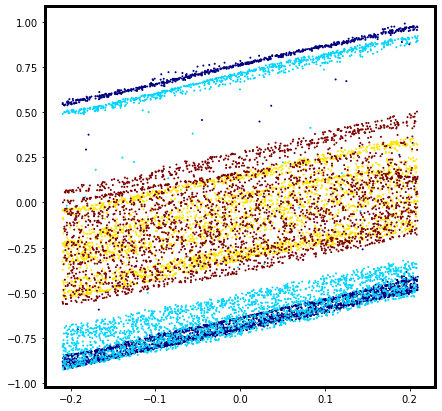

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images.
# The points are colored using the suit of the images.
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_all2), z_mean2[:,0], c = labels_all2, s =1, cmap = 'jet')

## cards-iii
High rotation (120 deg) Low shear (1 deg)

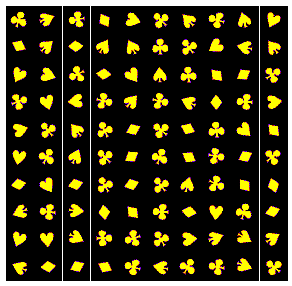

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all3))
    ax.imshow(cards_all3[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Downloading the saved model
!gdown 1gzoUZUOivFivjMl-_3K9ZDJlOqIG4Cz2

# Loading the saved model
jrvae3 = aoi.load_model('jrvae31.tar')

Downloading...
From: https://drive.google.com/uc?id=1gzoUZUOivFivjMl-_3K9ZDJlOqIG4Cz2
To: /content/jrvae31.tar
100% 117M/117M [00:03<00:00, 37.5MB/s]


Traverse Manifolds


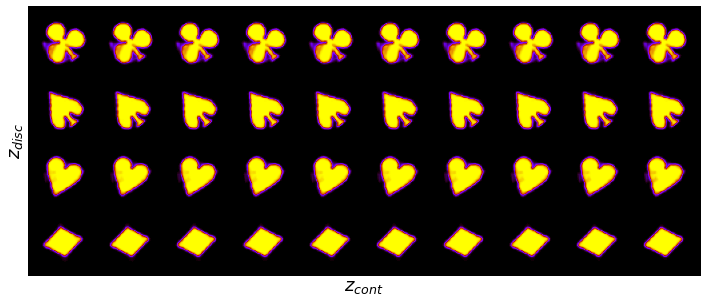

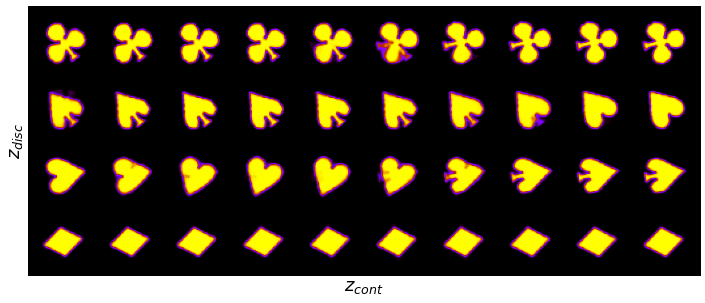

In [ ]:
# Traverse Manifolds

# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions.
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
# Since the latent space of crVAE is conditioned on the class label, we get one latent space for each class

# Traverse manifold is the decoded latent space in which one of the continouous latent dimension is held at constant (0),
# While the other continuous dimensions and the discrete dimension are used to plot the decoded latent space.

print('Traverse Manifolds')
for i in range(2):
    jrvae3.manifold_traversal(i, origin="upper")

Full class manifolds


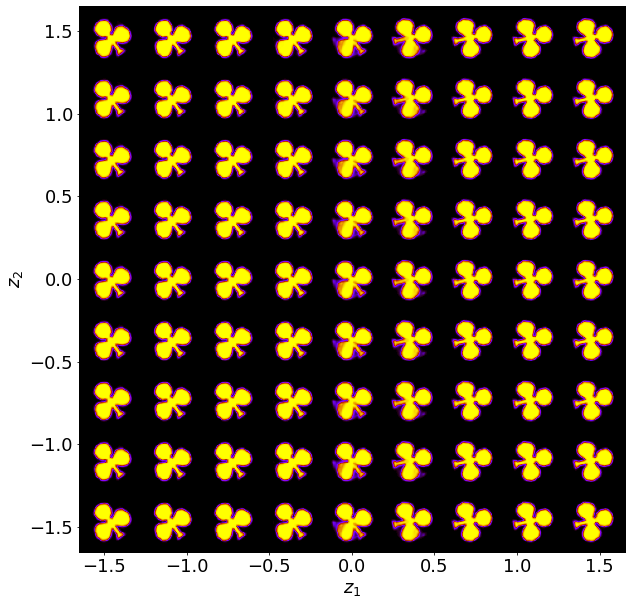

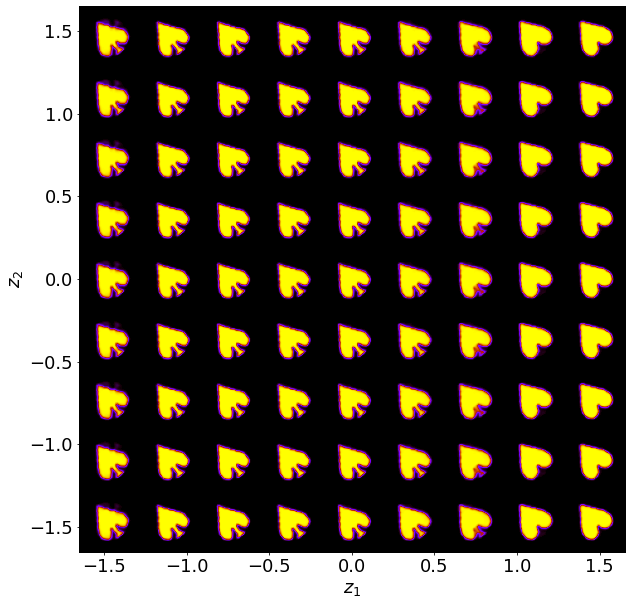

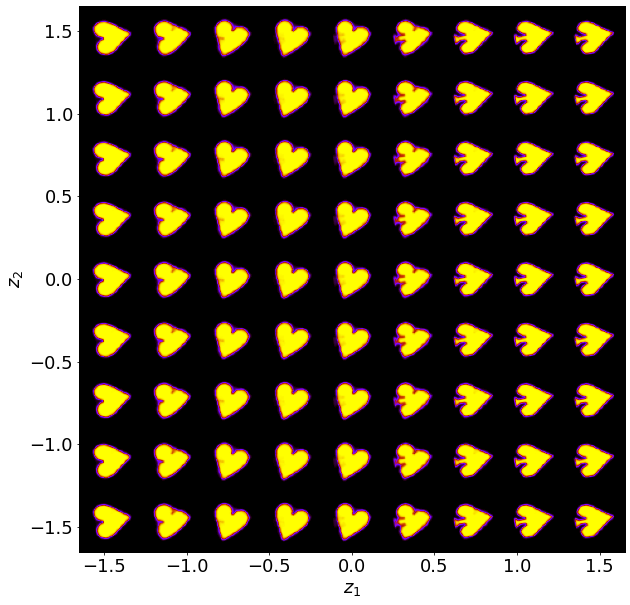

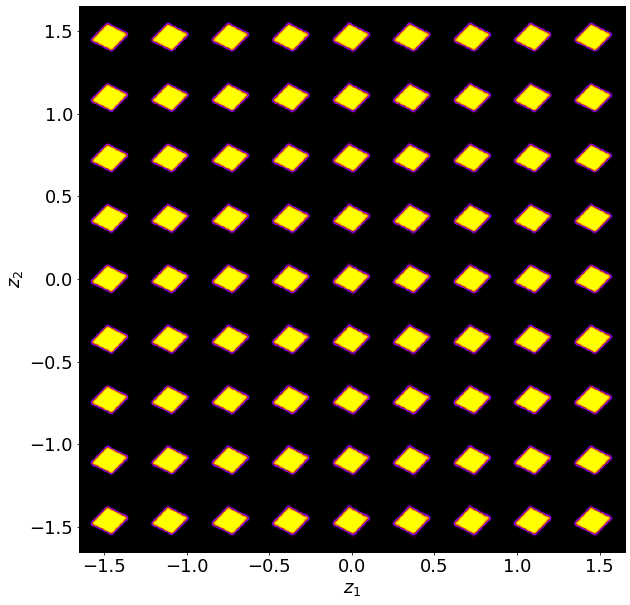

In [ ]:
# Decoded latent space of each class
print('Full class manifolds')
for i in range(4):
    jrvae3.manifold2d(d=9, disc_idx=i, origin="upper")

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution

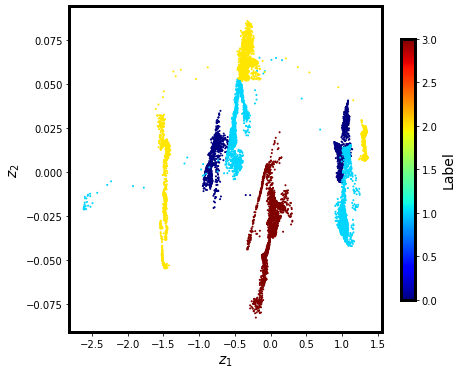

In [ ]:
z_mean3, z_sd3, alpha_all3 = jrvae3.encode(cards_all3)   # Encoding the full input dataset
# z_mean3: mean of the latent space representation of the input dataset,
# z_sd3: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions)
# alpha_all3: corresponds to the encoding in the discrete dimension

# Latent distribution colored using the ground-truth suit of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean3[:,-1], z_mean3[:,-2], c=labels_all3, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

# It should be noted that these points live in 4 independent latent spaces corresponding to the encodings in discrete dimension

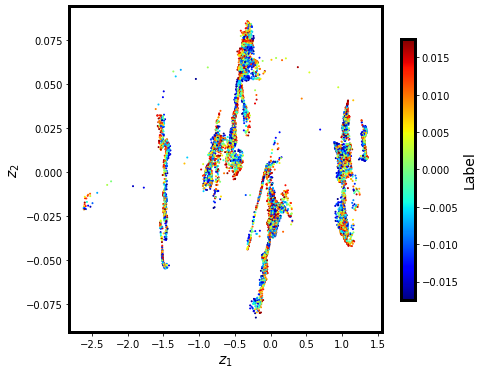

In [ ]:
# Latent distribution colored using the ground-truth shear of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean3[:,-1], z_mean3[:,-2], c=shears_all3[:,0], s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

# It should be noted that these points live in 4 independent latent spaces corresponding to the encodings in discrete dimension

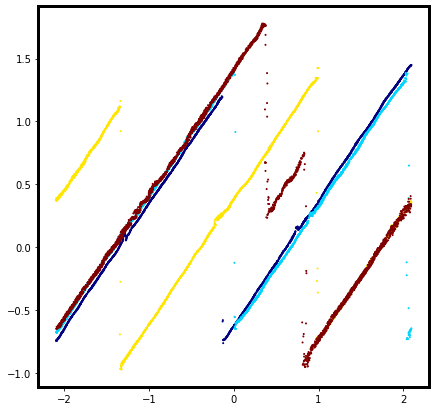

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images.
# The points are colored using the suit of the images.
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_all3), z_mean3[:,0], c = labels_all3, s =1, cmap = 'jet')

## cards-iv
High rotation (120 deg) and High shear (20 deg)

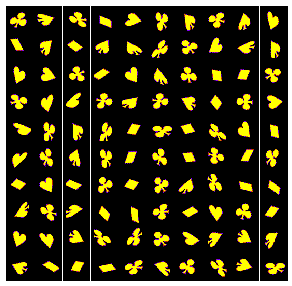

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all4))
    ax.imshow(cards_all4[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Downloading the saved model
!gdown 1qaAlzO7ZwboHetKNDISYXpRAbp3h9D-S

# Loading the saved model
jrvae4 = aoi.load_model('jrvae41.tar')

Downloading...
From: https://drive.google.com/uc?id=1qaAlzO7ZwboHetKNDISYXpRAbp3h9D-S
To: /content/jrvae41.tar
100% 117M/117M [00:03<00:00, 30.4MB/s]


Traverse Manifolds


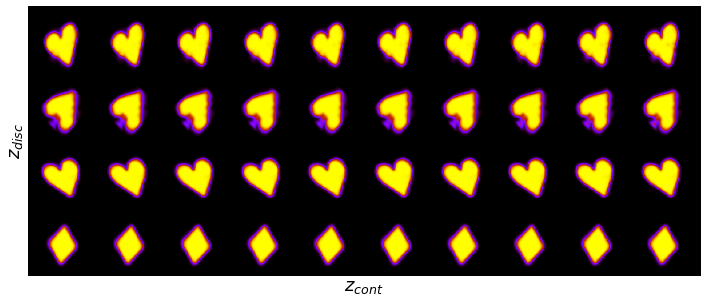

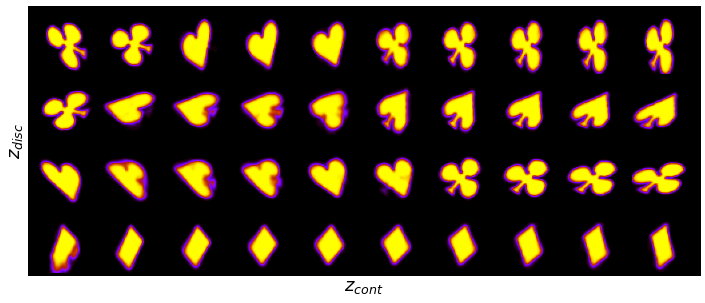

In [ ]:
# Traverse Manifolds

# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions.
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
# Since the latent space of crVAE is conditioned on the class label, we get one latent space for each class

# Traverse manifold is the decoded latent space in which one of the continouous latent dimension is held at constant (0),
# While the other continuous dimensions and the discrete dimension are used to plot the decoded latent space.
print('Traverse Manifolds')
for i in range(2):
    jrvae4.manifold_traversal(i, origin="upper")

Full class manifolds


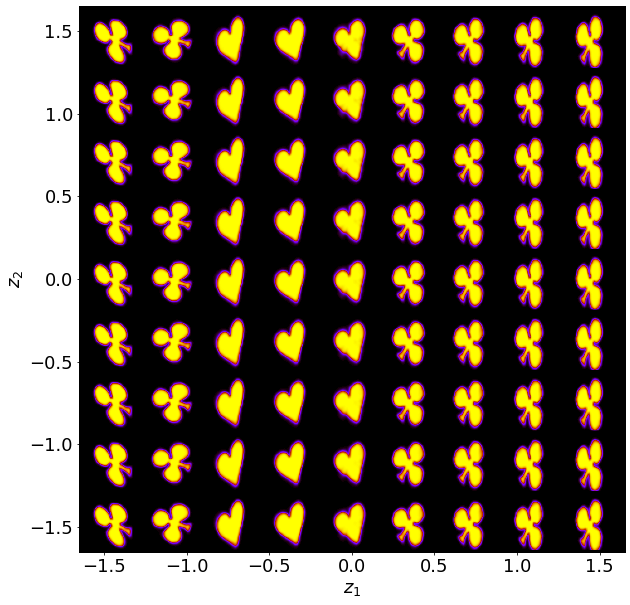

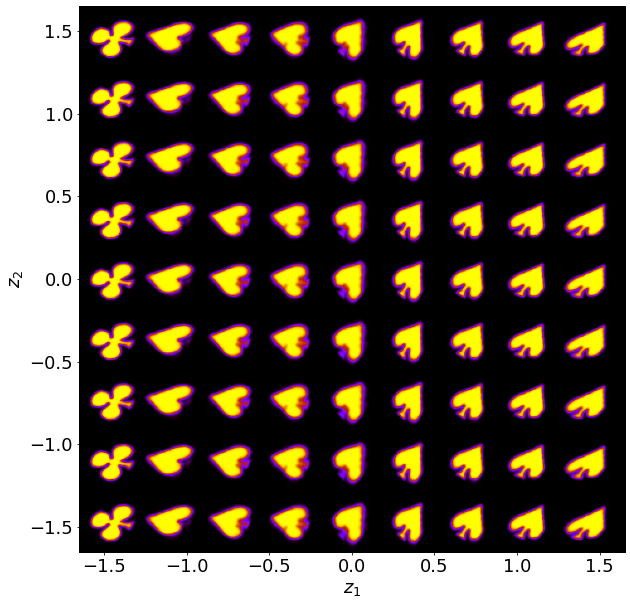

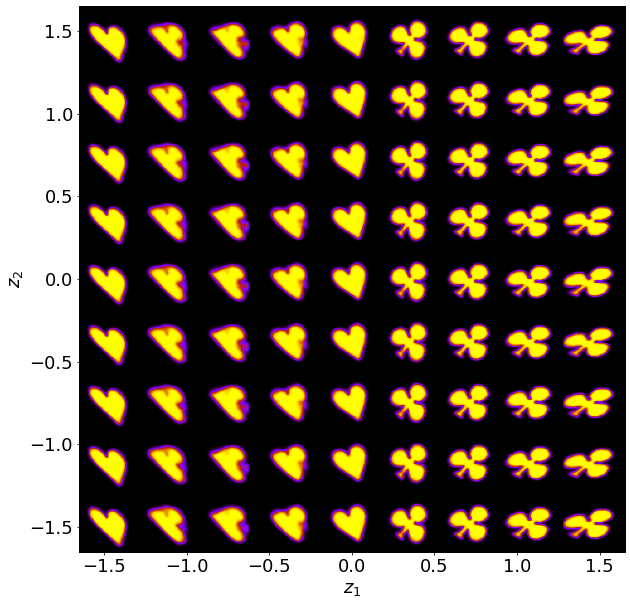

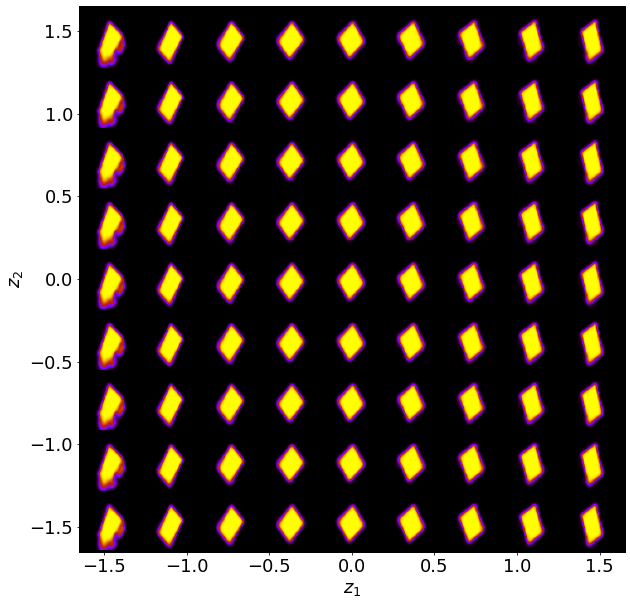

In [ ]:
# Decoded latent space of each class
print('Full class manifolds')
for i in range(4):
    jrvae4.manifold2d(d=9, disc_idx=i, origin="upper")

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution

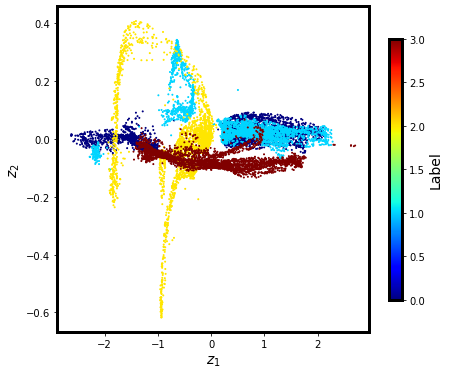

In [ ]:
z_mean4, z_sd4, alpha_all4 = jrvae4.encode(cards_all4)    # Encoding the full input dataset
# z_mean4: mean of the latent space representation of the input dataset,
# z_sd4: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions)
# alpha_all4: corresponds to the encoding in the discrete dimension

# Latent distribution colored using the ground-truth suit of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean4[:,-1], z_mean4[:,-2], c=labels_all4, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

# It should be noted that these points live in 4 independent latent spaces corresponding to the encodings in discrete dimension

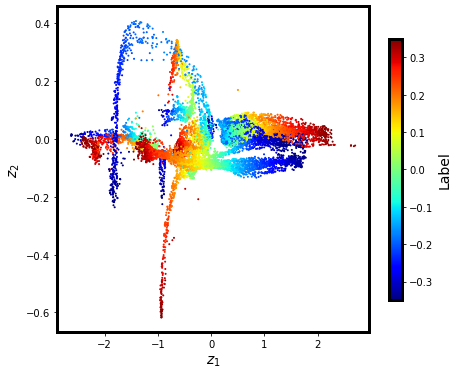

In [ ]:
# Latent distribution colored using the ground-truth shear of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean4[:,-1], z_mean4[:,-2], c=shears_all4[:,0], s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

# It should be noted that these points live in 4 independent latent spaces corresponding to the encodings in discrete dimension

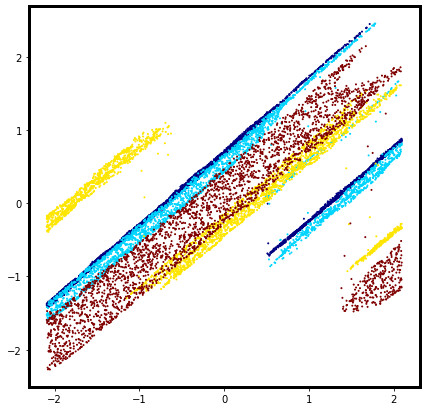

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images.
# The points are colored using the suit of the images.
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_all4), z_mean4[:,0], c = labels_all4, s =1, cmap = 'jet')